In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, Input, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Helper Functions
class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name="balanced_sparse_categorical_accuracy", dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)


def Plot_Loss_and_Acc(history):
  eff_epochs = len(history.history['loss'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(eff_epochs)

  plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  return None


def plot_confusion_matrix(model, target):
  X, y_true = list(zip(*[(X, y) for (X, y) in target.unbatch().as_numpy_iterator()]))
  y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
  acc = balanced_accuracy_score(y_true, y_hat)
  print(f"Final balanced accuracy on validation set : {acc:.3f}")
  mat = confusion_matrix(y_true, y_hat)
  sns.heatmap(mat, square=True, annot=True, cbar=True, cmap=plt.cm.Blues)
  plt.xlabel('Predicted Values')
  plt.ylabel('True Values')
  return None

In [ ]:
# Visual Transformer Implementation
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


class ViTClassfier(tf.keras.models.Model):
    def __init__(self, input_shape, n_classes, config={}):
        super(ViTClassfier, self).__init__()
        if not config:
          self._arch = {
            "patch_size" : 6,
            "embedding_dim" : 32,
            "n_heads" : 2,
            "n_transformers" : 1,
            "transformer_units" : [64, 32],
            "transformer_dropout" : 0.1,
            "mlp_units" : [2048, 1024],
            "mlp_dropout" : 0.1,
            "input_shape" : input_shape,
            "n_classes" : n_classes,
          }
        else:
          self._arch = config

        self._construct_model()

    def call(self, x):
        return self._model(x)

    def _construct_model(self):
        arch = self._arch

        num_patches = (arch["input_shape"][0] // arch["patch_size"]) ** 2

        inputs = Input(shape=arch["input_shape"])

        patches = Patches(arch["patch_size"])(inputs)
        # Encode patches.
        encoded_patches = PatchEncoder(num_patches, arch["embedding_dim"])(patches)

        # Create multipletf.keras.layers of the Transformer block.
        for _ in range(arch["n_transformers"]):
            # Layer normalization 1.
            x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = MultiHeadAttention(
                num_heads=arch["n_heads"], key_dim=arch["embedding_dim"], dropout=0.1
            )(x1, x1)
            # Skip connection 1.
            x2 = Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            for units in arch["transformer_units"]:
                x3 = Dense(units, activation=tf.nn.gelu)(x3)
                x3 = Dropout(arch["transformer_dropout"])(x3)

            # Skip connection 2.
            encoded_patches = Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        features = LayerNormalization(epsilon=1e-6)(encoded_patches)
        features = Flatten()(features)
        features = Dropout(0.5)(features)
        # Add MLP.
        for units in arch["mlp_units"]:
            features = Dense(units, activation=tf.nn.gelu)(features)
            features = Dropout(arch["mlp_dropout"])(features)
        # Classify outputs.
        logits = Dense(arch["n_classes"])(features)
        # Create the Keras model.
        self._model = Model(inputs=inputs, outputs=logits)

# Training

In [ ]:
data_path_train = '/content/drive/MyDrive/ECE247/Brain_Tumor_Project/ViT-Tumor-Classification-master/dataset/training' #use correct data path'

In [ ]:
hparams = {
    "image_size":(64, 64, 3),
    "n_classes":4,
    "batch_size":64,
}

ds = image_dataset_from_directory(data_path_train, image_size=hparams["image_size"][:-1], batch_size=hparams["batch_size"])
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 5712 files belonging to 4 classes.


In [ ]:
model_1 = ViTClassfier(hparams["image_size"], hparams["n_classes"])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
)

In [ ]:
for layer in model_1.layers:
    print(layer.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 patches (Patches)           (None, None, 108)            0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 100, 32)              6688      ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 100, 32)              64        ['patch_encoder[0][0]']   

In [ ]:
history_1 = model_1.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
72/72 [==============================] - 782s 10s/step - loss: 1.5357 - accuracy: 0.6504 - balanced_sparse_categorical_accuracy: 0.6485 - val_loss: 0.4360 - val_accuracy: 0.8333 - val_balanced_sparse_categorical_accuracy: 0.8200
Epoch 2/10
72/72 [==============================] - 59s 796ms/step - loss: 0.3945 - accuracy: 0.8589 - balanced_sparse_categorical_accuracy: 0.8525 - val_loss: 0.3316 - val_accuracy: 0.8967 - val_balanced_sparse_categorical_accuracy: 0.8887
Epoch 3/10
72/72 [==============================] - 78s 1s/step - loss: 0.2745 - accuracy: 0.9026 - balanced_sparse_categorical_accuracy: 0.8978 - val_loss: 0.2453 - val_accuracy: 0.9103 - val_balanced_sparse_categorical_accuracy: 0.9089
Epoch 4/10
72/72 [==============================] - 79s 1s/step - loss: 0.2068 - accuracy: 0.9234 - balanced_sparse_categorical_accuracy: 0.9201 - val_loss: 0.2306 - val_accuracy: 0.9130 - val_balanced_sparse_categorical_accuracy: 0.9062
Epoch 5/10
72/72 [=========================

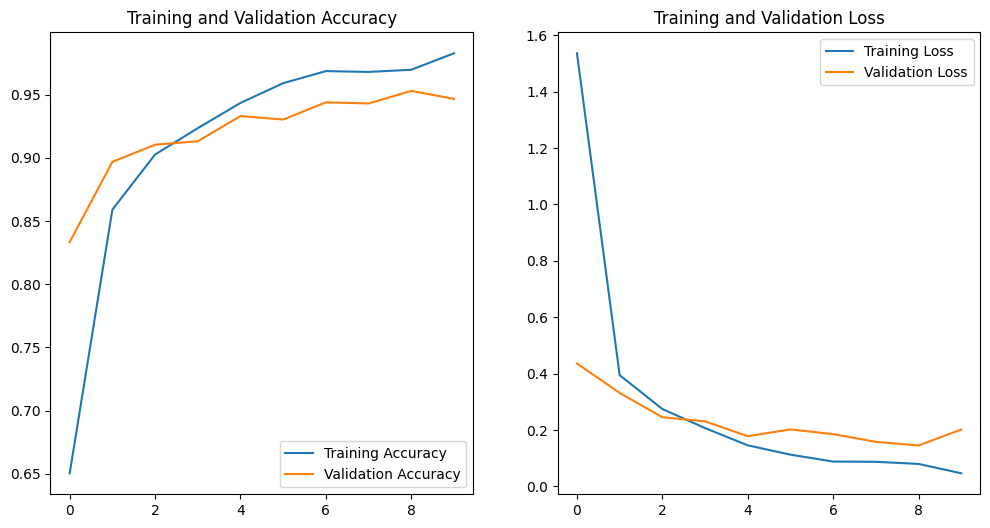

In [ ]:
Plot_Loss_and_Acc(history_1)

Final balanced accuracy on validation set : 0.946


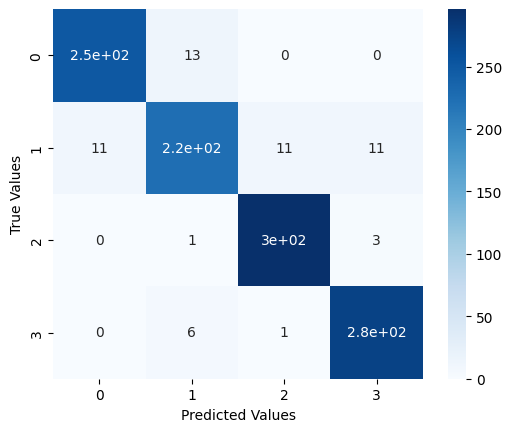

In [ ]:
plot_confusion_matrix(model_1, validation_ds)

## Fine Tuning Hyperparameters

In [ ]:
config = {"patch_size" : 10,
          "embedding_dim" : 32,
          "n_heads" : 3,
          "n_transformers" : 2,
          "transformer_units" : [64, 32],
          "transformer_dropout" : 0.4,
          "mlp_units" : [2048, 1024],
           "mlp_dropout" : 0.4,
           "input_shape" : hparams["image_size"],
           "n_classes" : hparams["n_classes"], }

model_2 = ViTClassfier(hparams["image_size"], hparams["n_classes"], config)

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
)

In [ ]:
history_2 = model_2.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
72/72 [==============================] - 64s 734ms/step - loss: 1.5234 - accuracy: 0.5632 - balanced_sparse_categorical_accuracy: 0.5633 - val_loss: 0.6046 - val_accuracy: 0.7853 - val_balanced_sparse_categorical_accuracy: 0.7734
Epoch 2/10
72/72 [==============================] - 51s 686ms/step - loss: 0.6264 - accuracy: 0.7639 - balanced_sparse_categorical_accuracy: 0.7607 - val_loss: 0.4189 - val_accuracy: 0.8533 - val_balanced_sparse_categorical_accuracy: 0.8460
Epoch 3/10
72/72 [==============================] - 70s 958ms/step - loss: 0.5189 - accuracy: 0.8151 - balanced_sparse_categorical_accuracy: 0.8094 - val_loss: 0.3322 - val_accuracy: 0.8741 - val_balanced_sparse_categorical_accuracy: 0.8708
Epoch 4/10
72/72 [==============================] - 59s 792ms/step - loss: 0.4415 - accuracy: 0.8424 - balanced_sparse_categorical_accuracy: 0.8340 - val_loss: 0.3187 - val_accuracy: 0.8804 - val_balanced_sparse_categorical_accuracy: 0.8789
Epoch 5/10
72/72 [==================

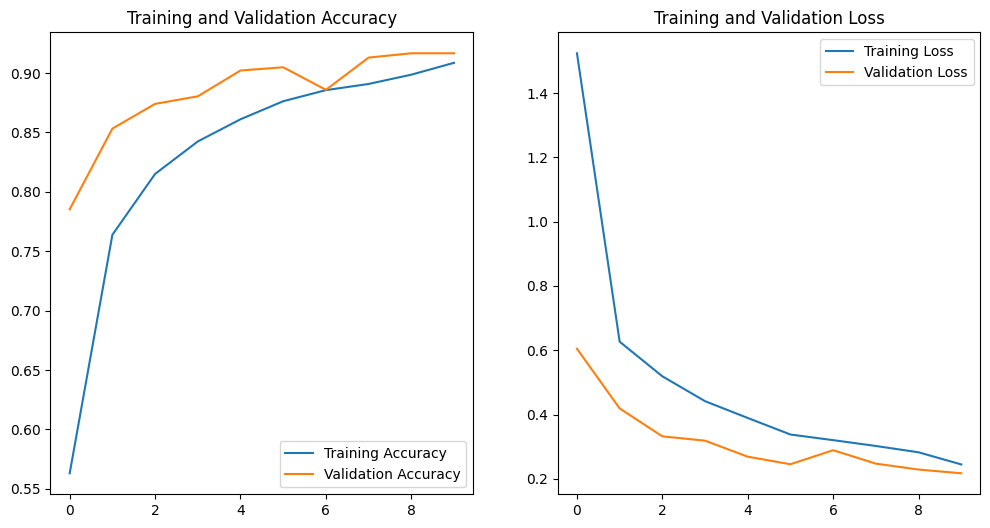

In [ ]:
Plot_Loss_and_Acc(history_2)

Final balanced accuracy on validation set : 0.909


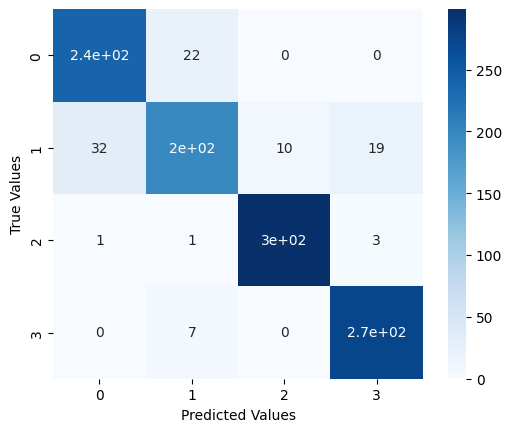

In [ ]:
plot_confusion_matrix(model_2, validation_ds)

In [ ]:
config = {"patch_size" : 10,
          "embedding_dim" : 32,
          "n_heads" : 3,
          "n_transformers" : 2,
          "transformer_units" : [64, 32],
          "transformer_dropout" : 0.1,
          "mlp_units" : [2048, 1024],
           "mlp_dropout" : 0.1,
           "input_shape" : hparams["image_size"],
           "n_classes" : hparams["n_classes"], }

model_3 = ViTClassfier(hparams["image_size"], hparams["n_classes"], config)

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
)

In [ ]:
history_3 = model_3.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
72/72 [==============================] - 79s 968ms/step - loss: 0.8834 - accuracy: 0.6756 - balanced_sparse_categorical_accuracy: 0.6694 - val_loss: 0.3980 - val_accuracy: 0.8578 - val_balanced_sparse_categorical_accuracy: 0.8503
Epoch 2/20
72/72 [==============================] - 73s 993ms/step - loss: 0.4418 - accuracy: 0.8388 - balanced_sparse_categorical_accuracy: 0.8349 - val_loss: 0.2844 - val_accuracy: 0.8986 - val_balanced_sparse_categorical_accuracy: 0.8898
Epoch 3/20
72/72 [==============================] - 70s 954ms/step - loss: 0.3466 - accuracy: 0.8772 - balanced_sparse_categorical_accuracy: 0.8719 - val_loss: 0.2468 - val_accuracy: 0.9076 - val_balanced_sparse_categorical_accuracy: 0.8896
Epoch 4/20
72/72 [==============================] - 53s 708ms/step - loss: 0.2619 - accuracy: 0.9000 - balanced_sparse_categorical_accuracy: 0.8984 - val_loss: 0.2147 - val_accuracy: 0.9167 - val_balanced_sparse_categorical_accuracy: 0.9121
Epoch 5/20
72/72 [==================

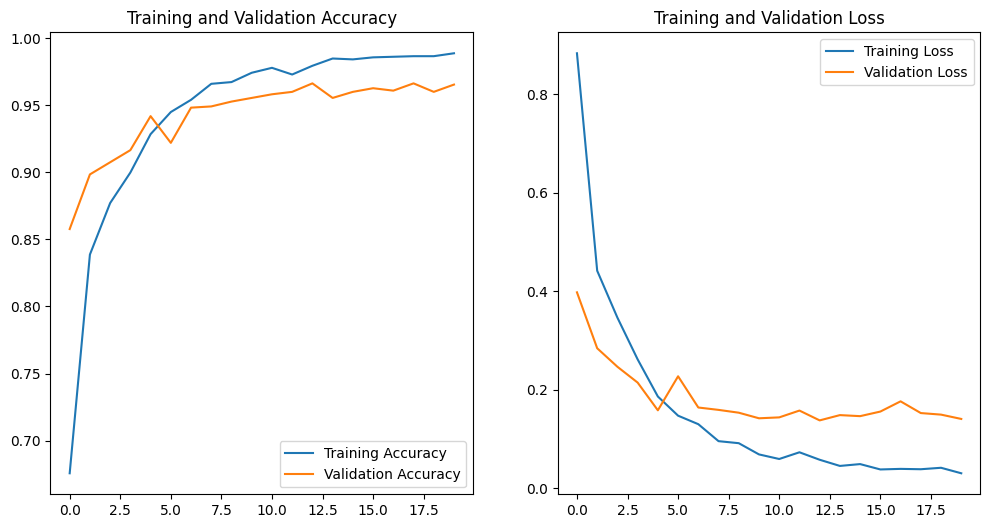

In [ ]:
Plot_Loss_and_Acc(history_3)

Final balanced accuracy on validation set : 0.964


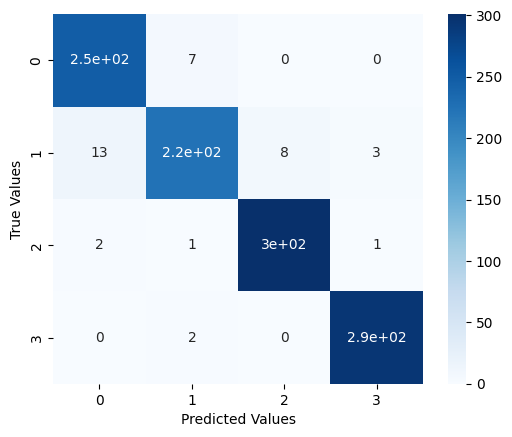

In [ ]:
plot_confusion_matrix(model_3, validation_ds)

# Testing

In [ ]:
data_path_test = '/content/drive/MyDrive/ECE247/Brain_Tumor_Project/ViT-Tumor-Classification-master/dataset/testing' #use correct data path'

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_path_test, image_size=hparams["image_size"][:-1], batch_size=hparams["batch_size"])
test_ds.class_names = test_ds.class_names

Found 1311 files belonging to 4 classes.


In [ ]:
# evaluate the best hyperparameter model based on val_acc
model_3.evaluate(test_ds)

21/21 [==============================] - 130s 4s/step - loss: 0.1925 - accuracy: 0.9489 - balanced_sparse_categorical_accuracy: 0.9469


[0.19247615337371826, 0.9488939642906189, 0.9469443559646606]

Final balanced accuracy on validation set : 0.945


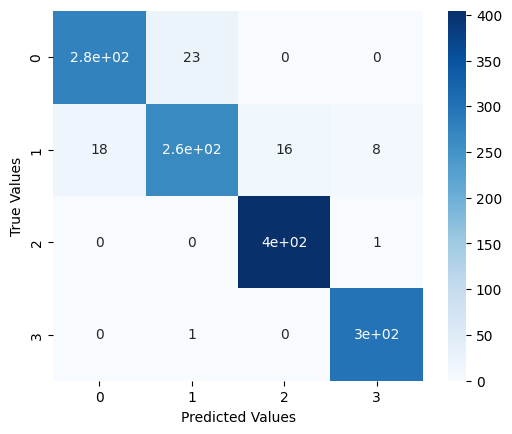

In [ ]:
plot_confusion_matrix(model_3, test_ds)